<Body>   
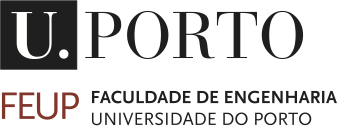   
<h1> <b>Machine Learning 2023/2024 (2<sup>nd</sup> semester) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt),
**Aníbal Matos** (anibal@fe.up.pt),
**Andry Pinto** (amgp@fe.up.pt),
**Daniel Campos** (dfcampos@fe.up.pt),
**Maria Inês Pereira** (maria.ines@fe.up.pt)

FEUP, Mar. 2024

---


# **Project #01**

**Note:** This is to be done in group of **2** elements. Use this notebook to answer all the questions. At the end of the work, you should **upload** both the **notebook** and a **pdf file** with a printout of the notebook with all the results in the **moodle** platform.

**Deadlines:** Present the state of your work (and answer questions) on the week of **March 18** in your corresponding practical class. Upload the files until 23:59 of **March 27, 2024**.


---



In [ ]:
# To make a nice pdf file of this file, you have to do the following:
# - upload this file into the running folder (click on the corresponding left icon)
# Then run this (which will make a html file into the current folder):
!jupyter nbconvert --to html "ML_project1.ipynb"
# Then just download the html file and print it to pdf!

[NbConvertApp] Converting notebook ML_project1.ipynb to html
[NbConvertApp] Writing 1701747 bytes to ML_project1.html


# **Identification**

* **Group:** A04_B
* **Name:** Bernardo de Almeida Soeiro
* **Student Number:** up202008204

* **Name:** Rodrigo de Vasconcelos e Miguel
* **Student Number:** up202008406


---




**Initial setup:** To download the file **data-set.cvs**, run the next cell.

In [ ]:
!wget -O dataset.csv.zip https://www.dropbox.com/s/9y0s2ogjovkwrbm/data-set.csv.zip?dl=0 --quiet
!unzip dataset.csv.zip -d.


Archive:  dataset.csv.zip
  inflating: ./data-set.csv          
  inflating: ./__MACOSX/._data-set.csv  


In [ ]:
# Then, run this code to get the data-set

import pandas as pd
df = pd.read_csv('data-set.csv', index_col=0)
df.head()
#df

# By convention, values that are zero signify no measurements.
# The units are:
# [m] for x and y
# [m/s] for the velocities vx and vy
# [m] for the LIDAR ranges

,time,x,y,vx,vy,angle -179,angle -178,angle -177,angle -176,angle -175,...,angle 171,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180
0,0.0,-3.946339,-2.912177,0.711051,-0.307325,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1,0.000000,0.000000,0.678366,-0.308563,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2,0.000000,0.000000,0.677682,-0.285029,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.3,0.000000,0.000000,0.648523,-0.293170,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4,0.000000,0.000000,0.644965,-0.277222,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Part 1: Kalman filter design**



Consider a holonomic mobile robot in the 2D plan and suppose that one can get measurements from its linear velocity every time step $t=0, 0.1, 0.2, \ldots$ (in seconds) and its position every time step $t=0, 0.5, 1.0, 1.5 \ldots$ (in seconds). Suppose also that the measurements are corrupted by additive Gaussian noise and furthermore, the linear velocity measurements may also include a unknown but constant bias term. The goal is to obtain an estimate of the position of the robot together with a measure of its uncertainty. To this end, we will implement a Kalman filter (KF)!

### **Model:**
Let $(x_t, y_t)$ be the position of the robot at time step $t$, and $(v_{x,t}, v_{y,t})$ its linear velocity. Let $(b_{x,t}, b_{y,t})$ be the bias term and $w_t$ and $\eta_t$ Gaussian noises. Then, a state-space model to design the KF can be written as


*x-direction*
\begin{align*}
\begin{bmatrix}
x_{t+1} \\
b_{x,t+1}
\end{bmatrix}
&= \begin{bmatrix}
1 &h \\
0 &1
\end{bmatrix}
\begin{bmatrix}
x_{t} \\
b_{x,t}
\end{bmatrix}
+\begin{bmatrix}
h \\
0
\end{bmatrix}
v_{x,t}
+ w_{x,t} \quad t=0, 0.1, 0.2, \ldots \\
z_{x,t} &=
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
x_{t} \\
b_{x,t}
\end{bmatrix} +  \eta_{x,t}, \quad t=0, 0.5, 1.0, 1.5 \ldots
\end{align*}

*y-direction*
\begin{align*}
\begin{bmatrix}
y_{t+1} \\
b_{y,t+1}
\end{bmatrix}
&= \begin{bmatrix}
1 &h \\
0 &1
\end{bmatrix}
\begin{bmatrix}
y_{t} \\
b_{y,t}
\end{bmatrix}
+\begin{bmatrix}
h \\
0
\end{bmatrix}
v_{y,t}
+ w_{y,t} \quad t=0, 0.1, 0.2, \ldots \\
z_{y,t} &=
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
y_{t} \\
b_{y,t}
\end{bmatrix} +  \eta_{y,t}, \quad t=0, 0.5, 1.0, 1.5 \ldots
\end{align*}
where $(z_{x,t}, z_{y,t})$ is the output vector and $h=0.1\,s$ is the sample time.

**Note:** We have decomposed the model in two decoupled parts (x and y directions). Thus, it is possible to design a KF for each direction.

**1.1**
Implement 2 KFs (one for each direction) and display the evolution along time of the estimated position of the robot and the estimated bias term. Display also the estimated trajectory 2D.

In [ ]:
import numpy as np
from numpy import *
from numpy.linalg import inv
import matplotlib.pyplot as plt

time = df["time"].values
x = df["x"].values
y = df["y"].values
vx = df["vx"].values
vy = df["vy"].values

# Filter out zero values for position x
non_zero_indices = df["x"].values != 0
timeFilt = df["time"].values[non_zero_indices]
xFilt = df["x"].values[non_zero_indices]

# Filter out zero values for position y
yFilt = df["y"].values[non_zero_indices]



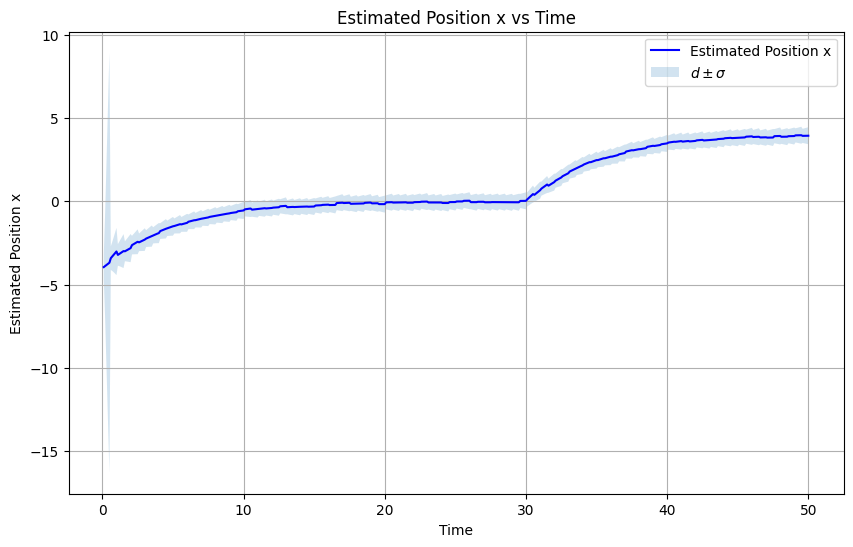

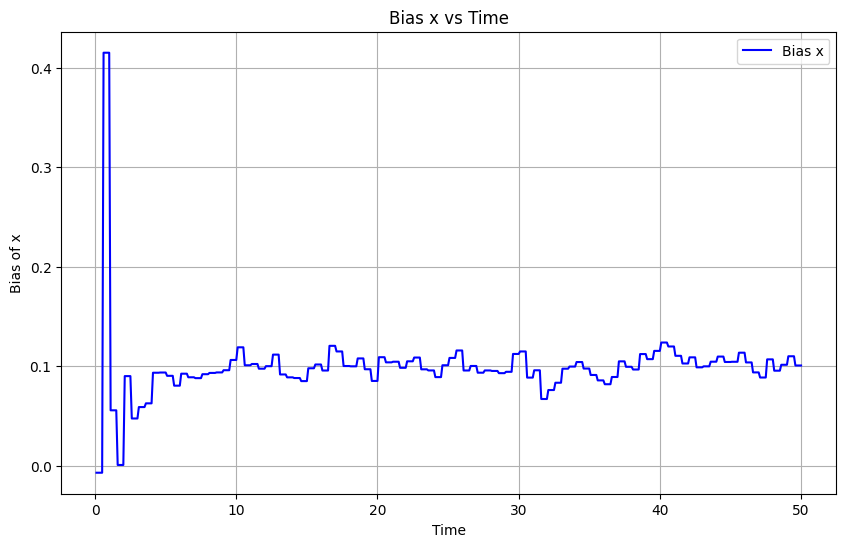

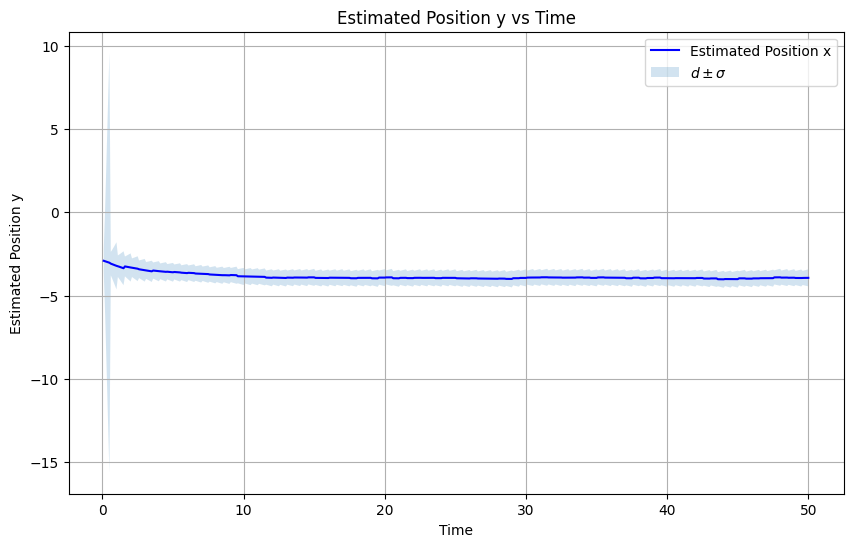

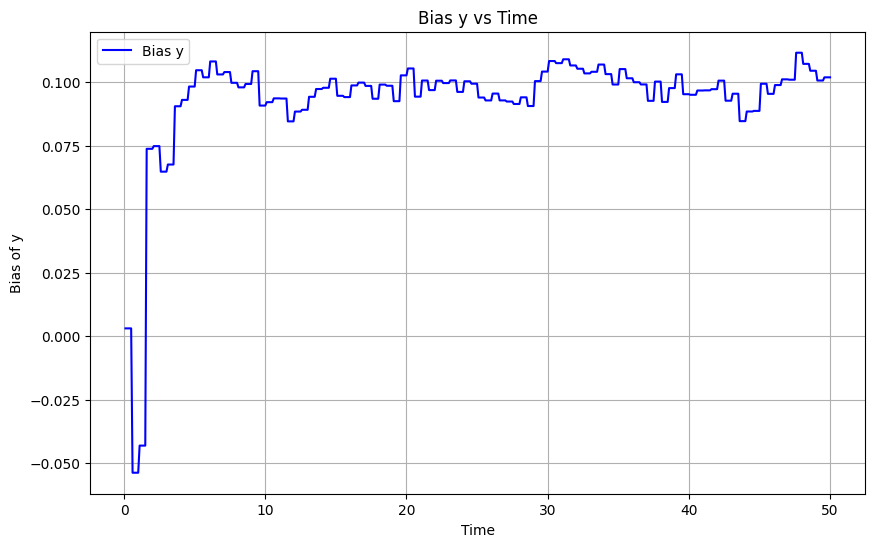

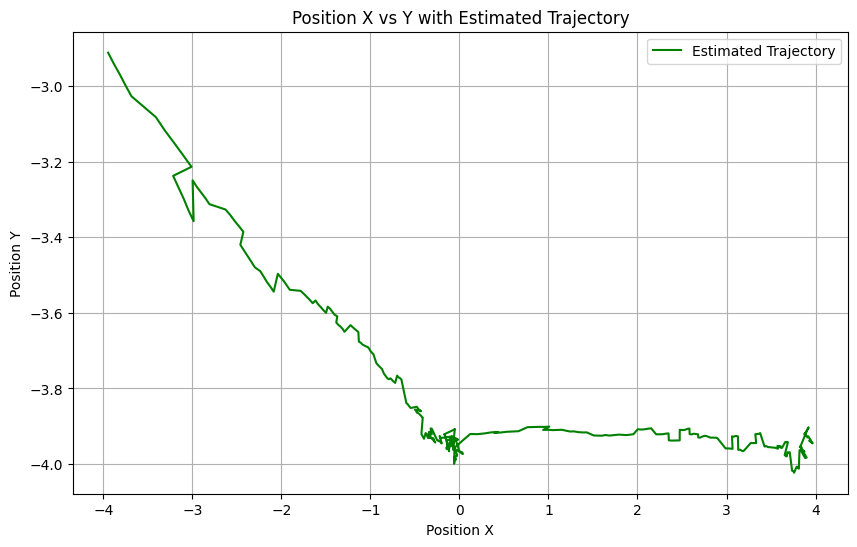

In [ ]:
# To complete

def kf_predict(X, P, A, Q, B, U):
    X = A @ X + B @ U
    P = A @ P@  A.T +Q
    return(X,P)

def kf_update(X, P, Y, H, R):
    IS = H @ P @ H.T + R
    K = P@H.T @ inv(IS)
    X = X + K @ (Y- H @ X)
    P = P- K @ IS @K.T
    return (X,P)



# Initial Values
qvalx=0.01
qvalb=0.001
rval=0.5
PI = np.pi

h = 0.1; #Inter sample time

Xx = np.array( [ [x[0]] , [0.0]]  ) # ini state x

Px = np.array( [ [ 999.0, 0.0 ] ,
                [ 0.0, 999.0 ] ]  ) # ini Covar x

Xy = np.array( [ [y[0]] , [0.0]]  ) # ini state y

Py = np.array( [ [ 999.0, 0.0 ] ,
                [ 0.0, 999.0 ] ]  ) # ini Covar y

A = np.array( [ [ 1.0, h ] ,
                [ 0.0, 1.0  ] ] ) # state matrix

B = np.array( [ [h], [0.0] ] ) # input effect matrix

H = np.array( [ [ 1.0, 0.0 ] ] ) # measurement matrix

R = np.array([ [rval] ] ) # measurement noise

Q = np.array([[qvalx, 0.0],
              [0.0, qvalb]]) # process noise


# For Plotting x
tx=0
tx_time = []
posx_time = []      # position of x over time (mean)
biasx_time = []      # bias of x over time (mean)
posx_sd_time = []   # position of x over time (std_dev)
biasx_sd_time = []   # bias of x over time (std_dev)
posx_up_time = []   # x mean + one std_dev
posx_dn_time = []   # x mean - one std_dev
biasx_up_time = []   # bias mean + one std_dev
biasx_dn_time = []   # bias mean - one std_dev

# For Plotting y
ty=0
ty_time = []
posy_time = []      # position of x over time (mean)
biasy_time = []      # bias of x over time (mean)
posy_sd_time = []   # position of x over time (std_dev)
biasy_sd_time = []   # bias of x over time (std_dev)
posy_up_time = []   # x mean + one std_dev
posy_dn_time = []   # x mean - one std_dev
biasy_up_time = []   # bias mean + one std_dev
biasy_dn_time = []   # bias mean - one std_dev

# Kalman Filter loop

N_iter = len(time)    # implies dt*N_iter seconds

for i in range(N_iter):
    tx+=h

    Ux = np.array([[vx[i].item()]])
    Uy = np.array([[vy[i].item()]])
    Zx = np.array([[x[i].item()]])
    Zy = np.array([[y[i].item()]])


    (Xx, Px) = kf_predict(Xx, Px, A, Q, B, Ux)
    (Xy, Py) = kf_predict(Xy, Py, A, Q, B, Uy)
    if i % 5 == 0:
      (Xx, Px) = kf_update(Xx, Px, Zx, H, R)
      (Xy, Py) = kf_update(Xy, Py, Zy, H, R)

    # X
    tx_time.append(tx)
    # save posX and bias
    posx_time.append(Xx[0].item())
    biasx_time.append(Xx[1].item())
    # save posX std and bias std
    posx_sd_time.append(sqrt(Px[0][0]).item())
    biasx_sd_time.append(sqrt(Px[1][1]).item())
    # save posX std
    posx_up_time.append( Xx[0].item() + sqrt( Px[0][0]).item() )
    posx_dn_time.append( Xx[0].item() - sqrt( Px[0][0]).item() )
    biasx_up_time.append( Xx[1].item() + sqrt( Px[1][1]).item() )
    biasx_dn_time.append( Xx[1].item() - sqrt( Px[1][1]).item() )

    # Y
    ty_time.append(tx)
    # save posy and bias
    posy_time.append(Xy[0].item())
    biasy_time.append(Xy[1].item())
    # save posy std and bias std
    posy_sd_time.append(sqrt(Py[0][0]).item())
    biasy_sd_time.append(sqrt(Py[1][1]).item())
    # save posy std
    posy_up_time.append( Xy[0].item() + sqrt( Py[0][0]).item() )
    posy_dn_time.append( Xy[0].item() - sqrt( Py[0][0]).item() )
    biasy_up_time.append( Xy[1].item() + sqrt( Py[1][1]).item() )
    biasy_dn_time.append( Xy[1].item() - sqrt( Py[1][1]).item() )

#X PLOT

# Plotting estimated position of x against time
plt.figure(figsize=(10, 6))
plt.plot(tx_time, posx_time, label='Estimated Position x', color='blue')
plt.fill_between(tx_time, posx_dn_time, posx_up_time, alpha=0.2, linewidth=0, label='$d\pm\sigma$')
plt.xlabel('Time')
plt.ylabel('Estimated Position x')
plt.title('Estimated Position x vs Time')
plt.grid(True)
plt.legend()
plt.show()
# Plotting std dev of x against time
plt.figure(figsize=(10, 6))
plt.plot(tx_time, biasx_time, label='Bias x', color='blue')
plt.xlabel('Time')
plt.ylabel('Bias of x')
plt.title('Bias x vs Time')
plt.grid(True)
plt.legend()
plt.show()

#Y PLOT

# Plotting estimated position of y against time
plt.figure(figsize=(10, 6))
plt.plot(ty_time, posy_time, label='Estimated Position x', color='blue')
plt.fill_between(ty_time, posy_dn_time, posy_up_time, alpha=0.2, linewidth=0, label='$d\pm\sigma$')
plt.xlabel('Time')
plt.ylabel('Estimated Position y')
plt.title('Estimated Position y vs Time')
plt.grid(True)
plt.legend()
plt.show()
# Plotting std dev of x against time
plt.figure(figsize=(10, 6))
plt.plot(tx_time, biasy_time, label='Bias y', color='blue')
plt.xlabel('Time')
plt.ylabel('Bias of y')
plt.title('Bias y vs Time')
plt.grid(True)
plt.legend()
plt.show()

#XY
# Plotting x against y
plt.figure(figsize=(10, 6))
#plt.scatter(posx_time, posy_time, label='Position', color='blue', marker='o')
plt.plot(posx_time, posy_time, linestyle='-', color='green', label='Estimated Trajectory')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('Position X vs Y with Estimated Trajectory')
plt.grid(True)
plt.legend()
plt.show()



**1.1 Justification**

The function **kf_predict** is responsible to compute the prediction step of the Kalman Filter:

\begin{align*}
\hat{x}^-_{n+1} &= A_{n} \hat{x}_{n} + B_n u_n \quad\quad \text{Predicted State Vector, mean values} \\
P^-_{n+1} &= A_{n} P_{n} A_{n}^T + Q_{n} \quad\quad \text{Predicted Covariance Matrix}
\end{align*}

Where:
 * **$A_n$** is the state matrix $\quad → A = \begin{bmatrix}1 & h \\0 & 1\\\end{bmatrix} $
 * **$B_n$** is the input effect matrix $\quad → B =\begin{bmatrix}h & 0 \\ \end{bmatrix} $
 * **$Q_n$** is the process noise matrix $\quad → Q=\begin{bmatrix}0.01 & 0 \\ 0 & 0.001\\ \end{bmatrix} $, it represents the varience of the process and because the error was unknown this value was tunned so that the trajectory was smoother.

The function **kf_update** is responsible to compute the update step of the Kalman Filter:

\begin{align*}
K_{n+1} &= P^-_{n+1} H^T_{n+1} (H_{n+1}P^-_{n+1}H^T_{n+1} + R_{n+1})^{-1} \quad\quad\quad \text{Kalman Gain} \\
\hat{x}_{n+1} &= \hat{x}^-_{n+1} + K_{n+1} (y_{n+1} - H_{n+1}\hat{x}^-_{n+1}) \quad\quad \text{Updated State Vector} \\
P_{n+1} &= P^-_{n+1} - K_{n+1} (H_{n+1}P^-_{n+1}H^T_{n+1} + R_{n+1}) K^T_{n+1} \quad\quad \text{Updated Covariance Matrix}
\end{align*}

Where:
 * **$H_n$** is the measurement matrix $\quad → H = \begin{bmatrix}1 & 0 \\\end{bmatrix} $
 * **$R_n$** is the measurement noise matrix $\quad → R =\begin{bmatrix}0.5 \\ \end{bmatrix}$, it represents the varience of the sensor measurements and because the sensor error was unknown this value was tunned so that the trajectory was smoother.

**All** of these values are the **same** for both the X-axis and the Y-axis Kalman Filters.

The initial values for the X-axis are $X_x = \begin{bmatrix}x[0] & 0 \end{bmatrix}$ and $P_x = \begin{bmatrix}999 & 0 \\0 & 999\end{bmatrix}$

The initial values for the Y-axis are $X_y = \begin{bmatrix}y[0] & 0 \end{bmatrix}$ and $P_y = \begin{bmatrix}999 & 0 \\0 & 999\end{bmatrix}$

The predict step is calculated every 0.1 seconds and the update step is calculated every 0.5 seconds. If there is no update the values that are stored are the ones calculated in the prediction step, otherwise the update values are stored.

The X-axis and Y-axis estimated position with its variance value and bias are then plotted.

Finally the estimated trajectory is plotted.

# **Part 2: Linear Regression**



In this part, the aim is to build a map of the environment by combining the position of the robot with the measurements of the 2D **LIDAR** that is on-board of the robot. The LIDAR measurements consist of range (distance) from the robot to a possible obstacle for each degree of direction, that is,
$$
r_t = \{r_\beta + \eta_r : \beta=-179^o, -178^o, \ldots, 0^o, \ldots, 180^o\}
$$
where $\eta_r$ is assumed to be Gaussian noise. The sample time is the same, that is, $h=0.1\,s$, but the LIDAR measurements are outputted every time step $t=0,0.5,1.0, 1.5, \ldots$ (in seconds) like the robot position in the previous exercise. Moreover, if there is no obstacle within the direction of the laser range or if it is far away, that is, if the distance is greater than $5\,m$, by convention the range measurement is set to zero. It may also happen that the LIDAR in some cases may output an *outlier*.

The next figure shows $r_t$ as a function of the angle $\beta$ for $t=5.0\,s$.

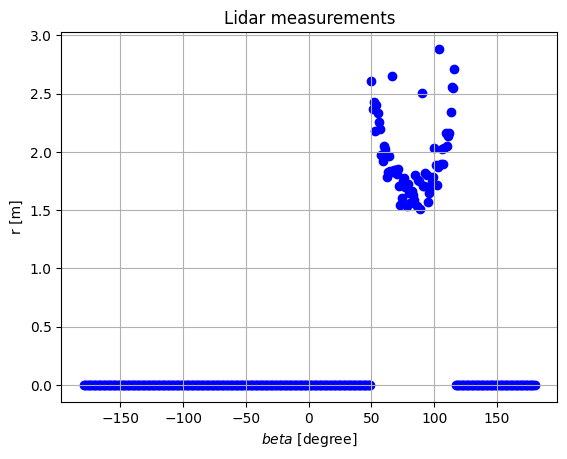

In [ ]:

time = df["time"].values
Lidar_range = df.iloc[:, np.arange(5,365,1)].values

t=5*10 # t = 5 sec * 1/sample_time
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();





**2.1**
Using the estimated position of the robot (computed in the previous exercise) and the LIDAR data,
1. Obtain the cloud points in the 2D plan that the robot sense at **$t=5\,s$** and plot them. Do not forget to remove the zero ranges and note that  

$$
\begin{align*}
\hat x_{o,t} = \hat x_t + r_t \cos\beta \\
\hat y_{o,t} = \hat y_t + r_t \sin\beta
\end{align*}
$$

2. Perform a linear regression for the previous data using a model of the type
\begin{equation} \color{green} { y = \theta_0 + \theta_1 x }
 \end{equation}
and display the results, that is, display the resulting 2d map, the mean square error, and the optimal parameters for $\color{green} \theta$. To this end, apply the related Least Square (LS) normal equations and **only use** the sklearn to confirm the obtained values.



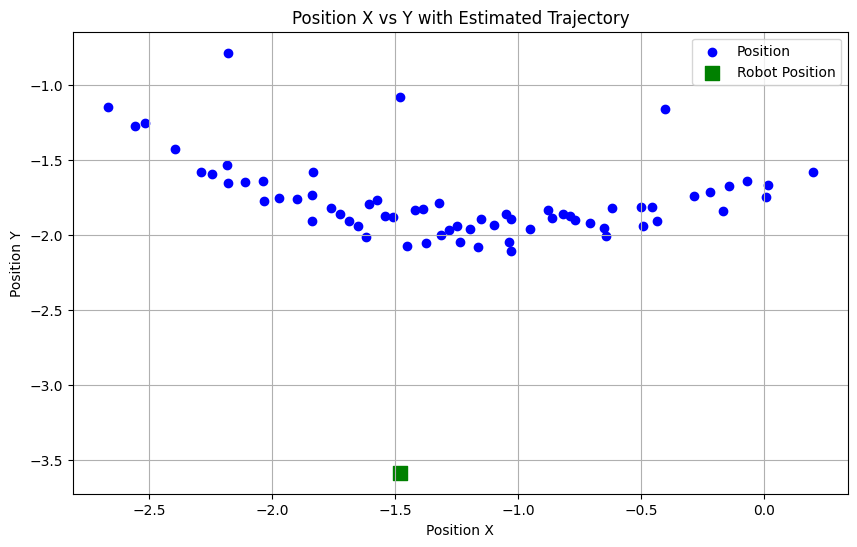

In [ ]:
# Part 2.1.1

#To complete

#Build the cloud points in 2D plan
x_o, y_o = [], []
n= 0
t=5*10 # t = 5 sec * 1/sample_time

angle = -179
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(posx_time[t] + Lidar_range[t][i] * np.cos(radians(angle+i)))
    y_o.append(posy_time[t] + Lidar_range[t][i] * np.sin(radians(angle+i)))

#point cloud
# Plotting x against y
plt.figure(figsize=(10, 6))
plt.scatter(x_o, y_o, label='Position', color='blue', marker='o')
plt.scatter(posx_time[t], posy_time[t], color='g', s= 100, marker ="s", label="Robot Position")
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('Position X vs Y with Estimated Trajectory')
plt.grid(True)
plt.legend()
plt.show()






**2.1.1 Justification**

In this code we will use **x_o** and **y_o**  that are empty lists to store the x and y coordinates of the points detected by the LiDAR following the given equations:
$$
\begin{align*}
\hat x_{o,t} = \hat x_t + r_t \cos\beta \\
\hat y_{o,t} = \hat y_t + r_t \sin\beta
\end{align*}
$$


Then the code uses matplotlib to create a scatter plot of the x and y coordinates. Each blue point on the plot represents the position of an object detected by the LiDAR, additionally, the current position of the robot is marked with a green square on the plot.

Theta: 
[[-1.9242079 ]
 [-0.12289806]]
MSE -  0.056577742699758245


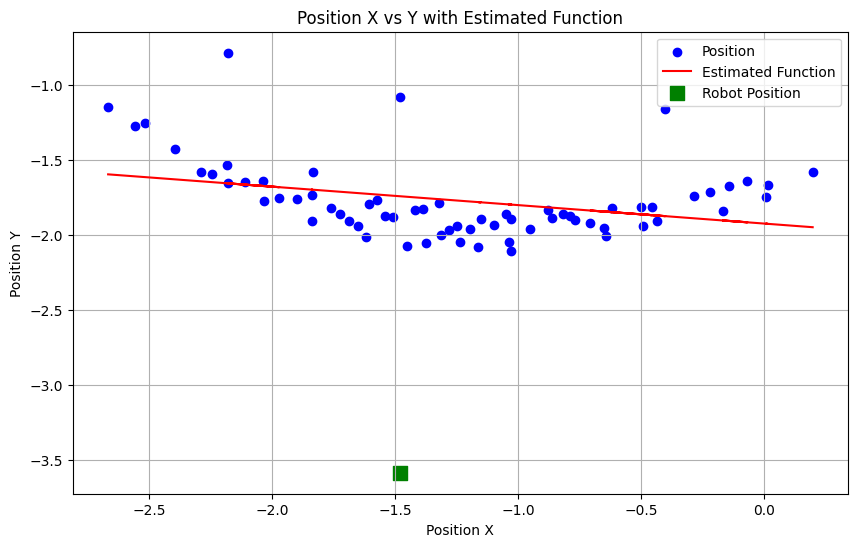

In [ ]:
from sklearn.metrics import mean_squared_error
# Part 2.1.2

#To complete
x_o_new = np.array(x_o)

# Create a matrix with the first column as 1's and the second column as x_o
X = np.column_stack((np.ones_like(x_o_new), x_o_new))

y_o = np.array(y_o)

# Reshape y_o into a column matrix
Y = np.reshape(y_o, (-1, 1))

theta = linalg.inv(X.T @ X) @ X.T @ Y
print("Theta: ")
print(theta)

y_predicted = theta[0] + theta[1] * x_o

MSE = mean_squared_error(y_o, y_predicted)
print("MSE - ", MSE)

# Plotting x against y
plt.figure(figsize=(10, 6))
plt.scatter(x_o, y_o, label='Position', color='blue', marker='o')
plt.plot(x_o, y_predicted, linestyle='-', color='red', label='Estimated Function')
plt.scatter(posx_time[t], posy_time[t], color='g', s= 100, marker ="s", label="Robot Position")
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('Position X vs Y with Estimated Function')
plt.grid(True)
plt.legend()
plt.show()


**2.1.2 Justification**

Firstly, the code prepares the data for regression by creating a matrix **X** with a column of ones and a column of **x_o** values. The target variable **y_o** is also prepared as a column matrix **Y**.

Next, the code calculates the parameters theta of the best-fit line using the equation provided:
 \begin{equation} \ { y = \theta_0 + \theta_1 x }
 \end{equation}
This involves matrix operations to find the values that minimize the cost function.
 \begin{equation}
\theta=(X^TX + \lambda I)^{-1}X^TY
 \end{equation}

Once the model parameters are determined, the code computes the predicted y values for each corresponding x value in the dataset. These predictions are used to calculate the Mean Squared Error (MSE), providing a quantitative measure of the model’s accuracy.

Finally, the code visualizes the results by plotting the original data points and the best-fit line on a scatter plot.






**2.2**
Repeat the previous exercise but now with a polynomial model of the type
\begin{equation} \color{green} { y = \theta_0 + \theta_1 x + \theta_2 x^2 }
 \end{equation}



Theta: 
[[-1.62807701]
 [ 0.59027178]
 [ 0.28829671]]
MSE -  0.031683826846264786


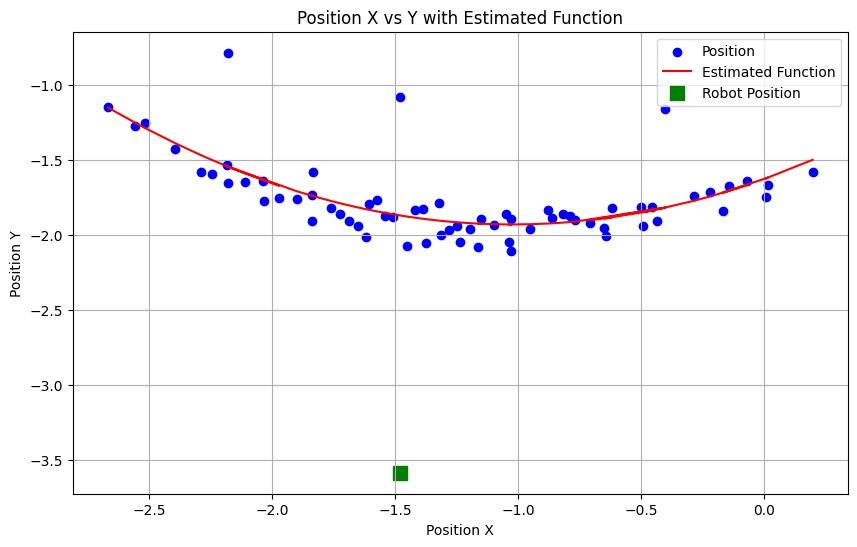

In [ ]:
#To complete
x_o_new = np.array(x_o)

# Create a matrix with the first column as 1's, the second column as x_o and the third colum as x_o**2
X = np.column_stack((np.ones_like(x_o_new), x_o_new, x_o_new**2))

y_o_new = np.array(y_o)

# Reshape y_o into a column matrix
Y = np.reshape(y_o_new, (-1, 1))

theta = linalg.inv(X.T @ X) @ X.T @ Y

print("Theta: ")
print(theta)

y_predicted = theta[0] + theta[1] * x_o_new + theta[2] * x_o_new**2

MSE = mean_squared_error(y_o, y_predicted)
print("MSE - ", MSE)
t=50
# Plotting x against y
plt.figure(figsize=(10, 6))
plt.scatter(x_o, y_o, label='Position', color='blue', marker='o')
plt.plot(x_o, y_predicted, linestyle='-', color='red', label='Estimated Function')
plt.scatter(posx_time[t], posy_time[t], color='g', s= 100, marker ="s", label="Robot Position")
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('Position X vs Y with Estimated Function')
plt.grid(True)
plt.legend()
plt.show()


**2.2 Justification**

In this code instead of implementing a linear regression model, which assumes a straight-line relationship between the independent variable **x_o** and the dependent variable **y_o** we extend it into a quadratic regression model by including an additional feature **x_o_new^2**. This allows the model to capture a parabolic relationship, which can fit data with curvature better than a straight line.
In thos quadratic regression model, the feature matrix **X** includes a third column, **x_o_new^2**, to accommodate the quadratic term.

**2.3**
At this point you can use sklearn!
Do the same as the previous exercise (polynomial model) but now with **degree 10**. Moreover, implement also a regression with **Ridge** regularization and a regression with **LASSO** regularization. Do not forget to display the obtained results. What can you conclude?




Linear MSE: 0.030178196986766232
Ridge MSE: 0.031015407205279382
Lasso MSE: 0.031180939308297344


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e+00, tolerance: 4.299e-04
  model = cd_fast.enet_coordinate_descent(


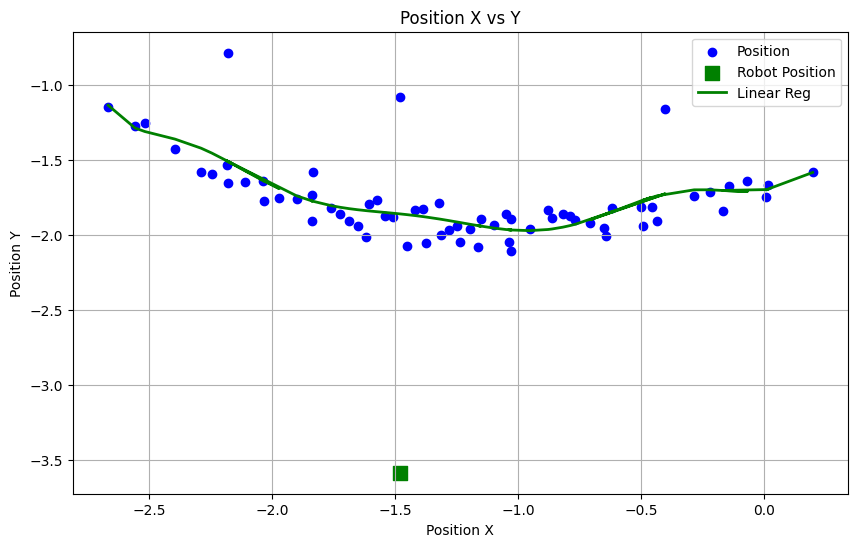

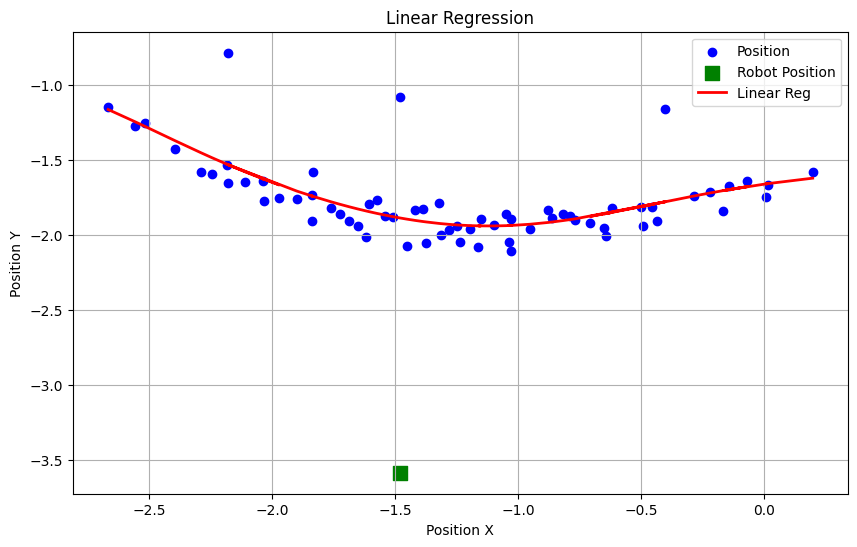

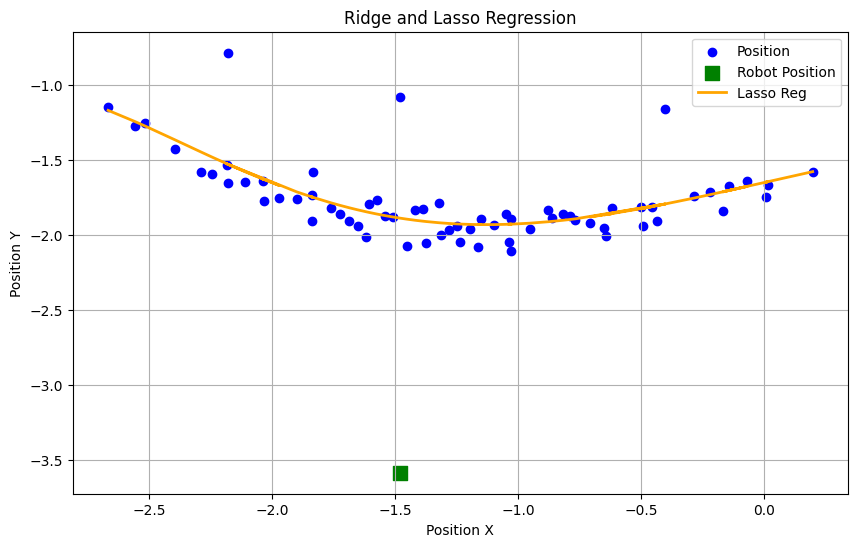

In [ ]:
# To complete

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso

poly_order = 10
poly_features_lin = PolynomialFeatures(poly_order)

# Transforming the 1D array x_o_new into a 2D array for use with PolynomialFeatures
X_o_new_2D = np.array(x_o_new).reshape(-1, 1)

# Creating polynomial features for the 2D array
X_poly_lin = poly_features_lin.fit_transform(X_o_new_2D)

# Fitting the linear regression model to the transformed data
lin_reg = LinearRegression()
lin_reg.fit(X_poly_lin, y_o_new)

# Making predictions with the fitted model
y_pred_lin = lin_reg.predict(X_poly_lin)

print("Linear MSE:", mean_squared_error(y_o_new, y_pred_lin))

# Ridge Regression
poly_features_ridge = PolynomialFeatures(poly_order)
X_poly_ridge = poly_features_ridge.fit_transform(X_o_new_2D)

ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(X_poly_ridge, y_o_new)

y_pred_ridge = ridge_reg.predict(poly_features_ridge.fit_transform(X_o_new_2D))
print("Ridge MSE:", mean_squared_error(y_o_new, y_pred_ridge))

# Lasso Regression
poly_features_lasso = PolynomialFeatures(poly_order)
X_poly_lasso = poly_features_lasso.fit_transform(X_o_new_2D)

lasso_reg = Lasso(alpha=0.0001)
lasso_reg.fit(X_poly_lasso, y_o_new)

y_pred_lasso = lasso_reg.predict(poly_features_lasso.fit_transform(X_o_new_2D))

print("Lasso MSE:", mean_squared_error(y_o_new, y_pred_lasso))




import matplotlib.pyplot as plt

# Primeira figura: Gráfico de dispersão da posição
plt.figure(figsize=(10, 6))
plt.scatter(x_o, y_o, label='Position', color='blue', marker='o')
plt.scatter(posx_time[t], posy_time[t], color='g', s=100, marker="s", label="Robot Position")
plt.plot(x_o, y_pred_lin, "green", lw=2, label="Linear Reg")
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('Position X vs Y')
plt.grid(True)
plt.legend()
plt.show()

# Segunda figura: Gráfico de Regressão Linear
plt.figure(figsize=(10, 6))
plt.scatter(x_o, y_o, label='Position', color='blue', marker='o')
plt.scatter(posx_time[t], posy_time[t], color='g', s=100, marker="s", label="Robot Position")
plt.plot(x_o, y_pred_ridge, "red", lw=2, label="Linear Reg")
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('Linear Regression')
plt.grid(True)
plt.legend()
plt.show()

# Terceira figura: Gráfico de Regressão Ridge e Lasso
plt.figure(figsize=(10, 6))
plt.scatter(x_o, y_o, label='Position', color='blue', marker='o')
plt.scatter(posx_time[t], posy_time[t], color='g', s=100, marker="s", label="Robot Position")
plt.plot(x_o, y_pred_lasso, "orange", lw=2, label="Lasso Reg")
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('Ridge and Lasso Regression')
plt.grid(True)
plt.legend()
plt.show()


 **2.3 Justification**

Initially, the code imports the necessary modules for creating polynomial features, fitting the models, and evaluating their performance. The PolynomialFeatures class is used to transform the original data into a new feature matrix that includes polynomial terms up to the specified degree, which is 10 in this case.
Then we implemet the Linear, Ridge e Lasso regreation

The Linear Regression model is a basic approach that does not include any regularization.

To address potential overfitting, Ridge and Lasso Regression models are employed, both of which introduce regularization terms. The alpha parameter in both Ridge and Lasso models controls the strength of the regularization. In this code, Ridge Regression uses an alpha value of 0.1, while Lasso Regression uses an alpha value of 0.0001. These values are chosen to demonstrate the effect of regularization on the polynomial regression models.

After fitting the models to the data, predictions are made, and the MSE is calculated for each model. The MSE provides a quantitative measure of the models’ accuracy, with lower values indicating better performance.



**2.4**
We now would like to use all the LIDAR data. One simple option (off-line) is to make a data set with all the cloud point positions in 2D and apply the linear regression techniques.

Using sklearn, do this for LS, LS+Ridge, LS+LASSO using the polynomial model of degree 10. Display the results (map 2D) and the optimal values for
$\color{green} \theta$.


Linear MSE: 0.11069549818639594
Ridge MSE: 0.11069560055230862


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e+02, tolerance: 1.556e-01
  model = cd_fast.enet_coordinate_descent(


Lasso MSE: 0.11357745234923135


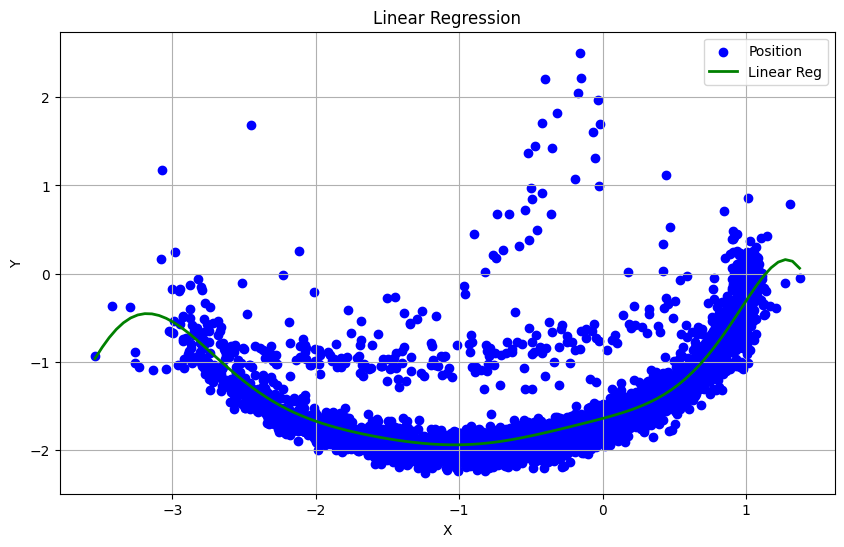

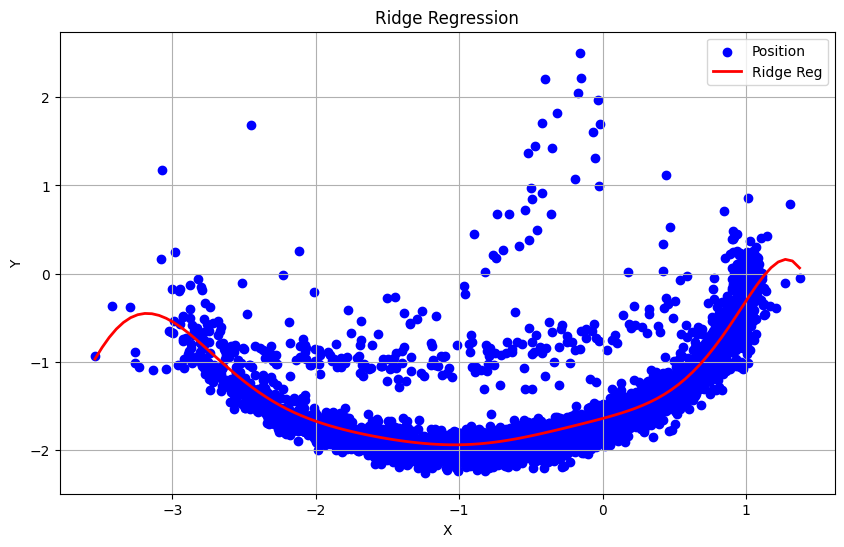

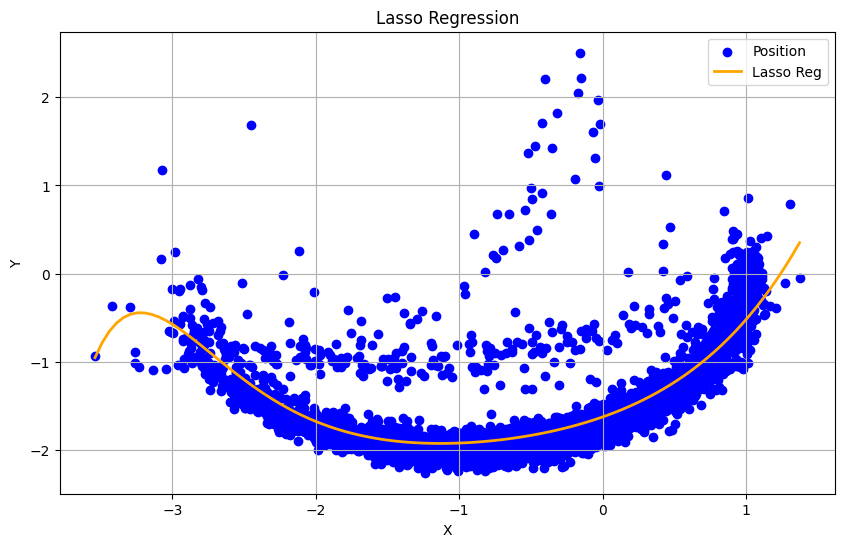

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error


x_oo, y_oo = [], []
x_m, y_m = [], []

angle = -179

for i in range(len(Lidar_range[t])):
    for t in range(len(time)):
        if Lidar_range[t][i] > 0:
            x_oo.append(posx_time[t] + Lidar_range[t][i] * np.cos(np.radians(angle + i)))
            y_oo.append(posy_time[t] + Lidar_range[t][i] * np.sin(np.radians(angle + i)))

x_oo_new = np.array(x_oo)
y_oo_new = np.array(y_oo)

# Define the range of x values for the polynomial regression
x_range = np.linspace(x_oo_new.min(), x_oo_new.max(), num=100)

poly_order = 10
poly_features_lin = PolynomialFeatures(poly_order)

# Transforming the 1D array x_oo_new into a 2D array for use with PolynomialFeatures
X_oo_new_2D = np.array(x_oo_new).reshape(-1, 1)

# Creating polynomial features for the 2D array
X_poly_lin = poly_features_lin.fit_transform(X_oo_new_2D)

# Fitting the linear regression model to the transformed data
lin_reg = LinearRegression()
lin_reg.fit(X_poly_lin, y_oo_new)

# Making predictions with the fitted model
y_pred_lin = lin_reg.predict(X_poly_lin)

print("Linear MSE:", mean_squared_error(y_oo_new, y_pred_lin))

# Ridge Regression
ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(X_poly_lin, y_oo_new)
y_pred_ridge = ridge_reg.predict(poly_features_lin.fit_transform(X_oo_new_2D))
print("Ridge MSE:", mean_squared_error(y_oo_new, y_pred_ridge))

# Lasso Regression
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_poly_lin, y_oo_new)
y_pred_lasso = lasso_reg.predict(poly_features_lin.fit_transform(X_oo_new_2D))
print("Lasso MSE:", mean_squared_error(y_oo_new, y_pred_lasso))
# Plotting the scatter plot of the position
plt.figure(figsize=(10, 6))
plt.scatter(x_oo, y_oo, label='Position', color='blue', marker='o')
#plt.scatter(posx_time[t], posy_time[t], color='g', s=100, marker="s", label="Robot Position")
plt.plot(x_range, lin_reg.predict(poly_features_lin.fit_transform(x_range.reshape(-1, 1))), "green", lw=2,
         label="Linear Reg")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Regression')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(x_oo, y_oo, label='Position', color='blue', marker='o')
#plt.scatter(posx_time[t], posy_time[t], color='g', s=100, marker="s", label="Robot Position")
plt.plot(x_range, ridge_reg.predict(poly_features_lin.fit_transform(x_range.reshape(-1, 1))), "red", lw=2,
         label="Ridge Reg")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ridge Regression')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Ridge and Lasso Regression
plt.figure(figsize=(10, 6))
plt.scatter(x_oo, y_oo, label='Position', color='blue', marker='o')
#plt.scatter(posx_time[t], posy_time[t], color='g', s=100, marker="s", label="Robot Position")
plt.plot(x_range, lasso_reg.predict(poly_features_lin.fit_transform(x_range.reshape(-1, 1))), "orange", lw=2,
         label="Lasso Reg")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lasso Regression')
plt.grid(True)
plt.legend()
plt.show()


**2.4 Justification**

In this excercise we implenment the same consepts as in 2.3 but we increase our dataset by using all the LIDAR data available

**2.5 (Extra)**
Another option (on-line) is to make a linear regression with only the LIDAR data that is being acquired at each snapshot of time $t=0, 0.5, 1.0, \ldots$ and update the optimal value $ \theta$ using a gradient descent rule
$$
{\theta_{t+1}=\theta_t - \gamma \nabla J(\theta_t),}
$$
where $ \gamma>0$ is the learning rate, and $
 {\nabla J(\theta_{t})}$ is the gradient at each snapshot of the cost
$$
{J(\theta) = \sum_{n=1}^N \big(y_n-\theta^{T} \phi(x_n)\big)^2 }
$$
where $N$ is the number of valid (that is non zero) range measurements at instant $t$.

Implement this strategy and plot the results.

**Note:** This question is optional. If you solve it, you get extra 15 points (in 100).

Iteration: 0   [Theta0, Theta1]: [0. 0.]                   J(): 214.09853120269736
Iteration: 100  [Theta0, Theta1]: [-1.48619475  0.16518136] J(): 6.965121182917253
Iteration: 200  [Theta0, Theta1]: [-1.78713052 -0.03274284] J(): 4.101608687903067
Iteration: 300  [Theta0, Theta1]: [-1.88130917 -0.09468374] J(): 3.821158101350618
Iteration: 400  [Theta0, Theta1]: [-1.91078263 -0.11406831] J(): 3.793690949859379
Iteration: 500  [Theta0, Theta1]: [-1.92000642 -0.12013477] J(): 3.7910008345691333
Iteration: 600  [Theta0, Theta1]: [-1.92289303 -0.12203328] J(): 3.790737366394172
Iteration: 700  [Theta0, Theta1]: [-1.92379641 -0.12262742] J(): 3.790711562489235
Iteration: 800  [Theta0, Theta1]: [-1.92407912 -0.12281336] J(): 3.7907090352712505
Iteration: 900  [Theta0, Theta1]: [-1.9241676  -0.12287155] J(): 3.790708787757134
Iteration: 1000 [Theta0, Theta1]: [-1.92419528 -0.12288976] J(): 3.790708763515759


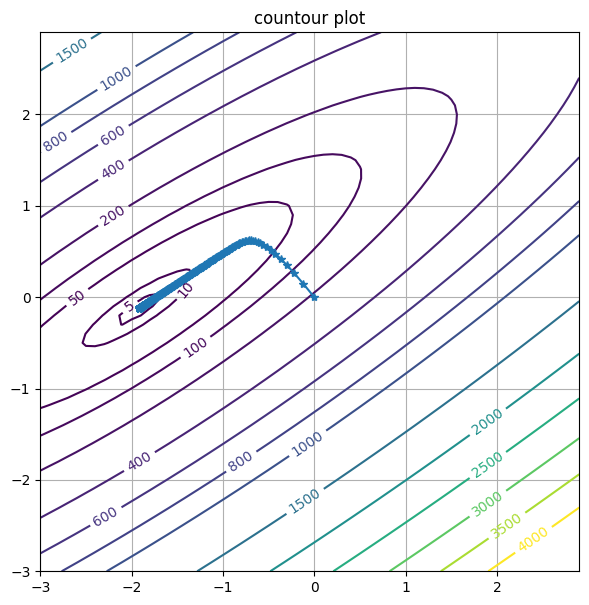

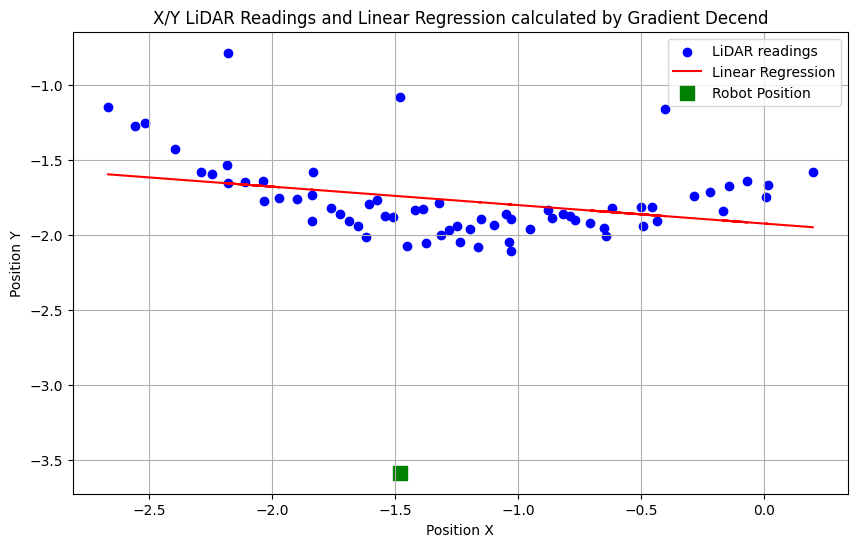

In [ ]:
# To complete


import numpy as np
import matplotlib.pyplot as plt

def J_func(theta0,theta1) :
  J=0
  for i in range(len(x_o)) :
    J = J + (y_o[i]-(theta0 + theta1*x_o[i]))**2
  return J

def J_grad(theta0,theta1) :
  dt0=0
  dt1=0
  for i in range(len(x_o)) :
    dt0 = dt0 + (-2*y_o[i] + 2*theta0 + 2*theta1*x_o[i])
    dt1 = dt1 + (-2*y_o[i]*x_o[i] +2*theta0*x_o[i] +2 * x_o[i]**2 *theta1)
  return dt0, dt1

#Getting x/y point cloud in time = 5s
time = df["time"].values
Lidar_range = df.iloc[:, np.arange(5,365,1)].values
angle = np.linspace(-179, 180, num=360)
x_o, y_o = [], []
n= 0
t=5*10 # t = 5 sec * 1/sample_time
angle = -179
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(posx_time[t] + Lidar_range[t][i] * np.cos(radians(angle+i)))
    y_o.append(posy_time[t] + Lidar_range[t][i] * np.sin(radians(angle+i)))


# step size
gamma = 0.0005
# number of iterations
MAX_ITER = 1000

points = np.zeros((MAX_ITER+1,2))

# initial point
theta0_0,theta1_0 = 0,0

# gradient descent method
points[0] = [theta0_0,theta1_0]

for i in range(MAX_ITER) :
  if i % 100 == 0 :
    if i == 0 :
      print("Iteration:", i, "  [Theta0, Theta1]:",points[i],"                  J():",J_func(points[i][0],points[i][1]))
    else:
      print("Iteration:", i, " [Theta0, Theta1]:",points[i],"J():",J_func(points[i][0],points[i][1]))

  dtheta1,dtheta2 = J_grad(points[i][0],points[i][1])
  points[i+1][0] = points[i][0] - gamma*dtheta1
  points[i+1][1] = points[i][1] - gamma*dtheta2

print("Iteration:",i+1,"[Theta0, Theta1]:", points[i+1],"J():", J_func(points[i+1][0],points[i+1][1]))

th0 = points[i+1][0]
th1 = points[i+1][1]

x_o_n = np.array(x_o)

y_predicted = th0 + th1 * x_o_n

STEP = 0.1
theta0 = np.arange(-3,3,STEP)
theta1 = np.arange(-3,3,STEP)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
J = np.zeros_like(Theta0)

for i in range(len(x_o)):
    J += (Theta0 + Theta1 * x_o[i] - y_o[i]) ** 2

fig, ax = plt.subplots(figsize=(7,7))
contour_levels = [5, 10, 50, 100, 200,400,600,800,1000,1500, 2000, 2500,3000, 3500,4000]

# Plot the contour lines
cs = ax.contour(Theta0, Theta1, J, levels=contour_levels)
ax.clabel(cs, inline=True, fontsize=10)
ax.set_aspect('equal')
ax.set_title('countour plot')
plt.grid()
plt.plot(points[:,0],points[:,1],'-*')

plt.show()

# Plotting the obstacle
plt.figure(figsize=(10, 6))
plt.scatter(x_o, y_o, label='LiDAR readings', color='blue', marker='o')
plt.plot(x_o, y_predicted, linestyle='-', color='red', label='Linear Regression')
plt.scatter(posx_time[t], posy_time[t], color='g', s= 100, marker ="s", label="Robot Position")
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('X/Y LiDAR Readings and Linear Regression calculated by Gradient Decend')
plt.grid(True)
plt.legend()
plt.show()


**2.5 Justification:**

The vectors x_o and y_o store all the points detected by the sensor at 5 seconds, that corresponds to the 50th sample set.

The function **J_func** is responsible to compute the equation:
$$
{J(\theta) = \sum_{n=1}^N \big(y_n-\theta^{T} \phi(x_n)\big)^2 }
$$
Where:
\begin{equation}{ \theta^{T} \phi(x_n) = \theta_0 + \theta_1 x }
 \end{equation}

 The function **J_grad** is responsible to compute the gradient of the previous function:

\begin{align*}
\nabla J(\theta) &= \begin{pmatrix} \frac{\partial J(\theta)}{\partial \theta_0} \\ \frac{\partial J(\theta)}{\partial \theta_1} \end{pmatrix} = \begin{pmatrix} -2\sum_{n=1}^N (y_n - \theta_0 - \theta_1 x_n) \\ -2\sum_{n=1}^N (y_n - \theta_0 - \theta_1 x_n)x_n \end{pmatrix}
\end{align*}



The **Gradient Descend Method** is performed 1000 iterations, with γ=0.0005 and intial Θ=[0, 0] :

$$
\theta_{k+1}=\theta_k - \gamma \nabla J(\theta_k),
$$

The evolution of **Θ** values and the value of the **Cost** are **printed** every 100 iterations. To better visualize the evolution of Θ a **Countour Plot** of J and every iteration of Θ are shown. The final values of Θ are used to plot the line that illustrate the prediction of the obstacle that is being detected by the LiDAR, represented by:

\begin{equation}{ y=\theta_0 + \theta_1 x }
 \end{equation}

In the same figure as all the points [x_o, y_o]. It is possible to see in the plot that the linear regression follow the tendencies of the points, what shows the good results of the Gradient Descend Method.